# Graph with Python: Basics, Metrics, and Algorithms

This notebook mainly follows the Medium blog from Ani Madurkar, [Graph Machine Learning with Python Part 1: Basics, Metrics, and Algorithms](https://towardsdatascience.com/graph-machine-learning-with-python-pt-1-basics-metrics-and-algorithms-cc40972de113)

## 0. Data Source

Football dataset (M. Girvan and M. E. J. Newman, Community structure in social and biological networks, Proc. Natl. Acad. Sci. USA 99, 7821–7826 (2002))

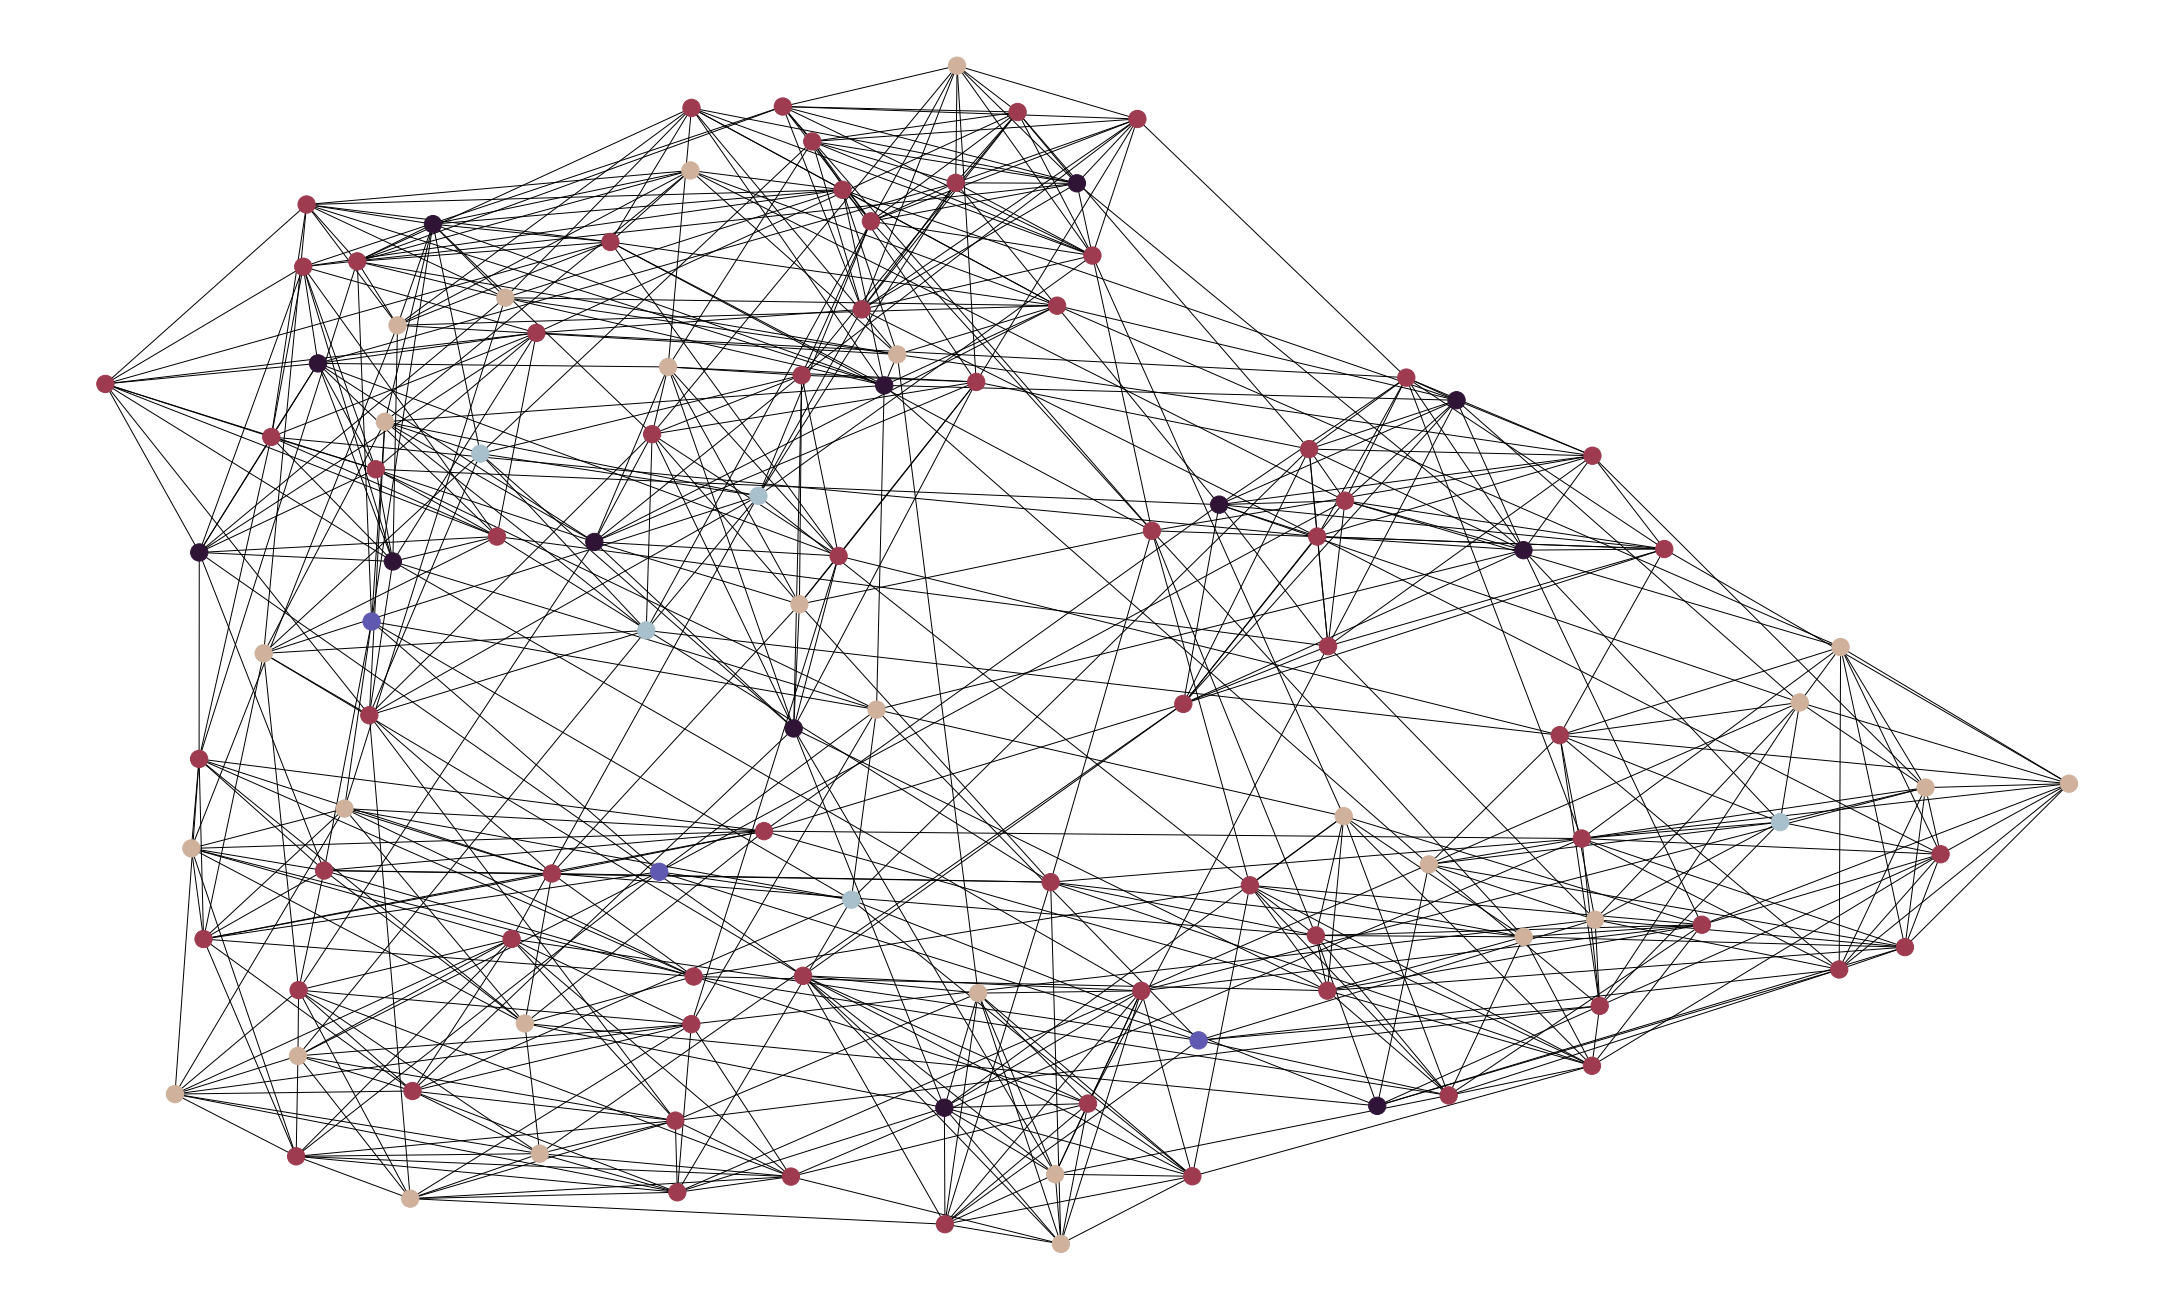

In [43]:
import urllib
import io
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import networkx as nx
import numpy as np
import pandas as pd

url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"

sock = urllib.request.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read("football.txt").decode()  # read info file
gml = zf.read("football.gml").decode()  # read gml data
# throw away bogus first line with # from mejn files
gml = gml.split("\n")[1:]
G = nx.parse_gml(gml)  # parse gml data

d = dict(G.degree)
low, *_, high = sorted(d.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.twilight_shifted)

options = {
    "node_size": 50,
    "linewidths": 0,
    "width": 0.1,
}

plt.figure(figsize =(30, 18))
nx.draw(G, 
        nodelist=d,
        node_color=[mapper.to_rgba(i) 
                    for i in d.values()])
plt.show()

## 1. Graph Summary

In [24]:
graph_degree = dict(G.degree)
print("Graph Summary:")
print(f"Number of nodes : {len(G.nodes)}")
print(f"Number of edges : {len(G.edges)}")
print(f"Maximum degree : {np.max(list(graph_degree.values()))}")
print(f"Minimum degree : {np.min(list(graph_degree.values()))}")
print(f"Average degree : {np.mean(list(graph_degree.values()))}")
print(f"Median degree : {np.median(list(graph_degree.values()))}")

Graph Summary:
Number of nodes : 115
Number of edges : 613
Maximum degree : 12
Minimum degree : 7
Average degree : 10.660869565217391
Median degree : 11.0


## 2. Network Connectivity

A connected graph is a graph where every pair of nodes has a path between them. In a graph, there can be multiple connected components; these are subsets of nodes such that: 1. every node in the subset has a path to every other node, 2. no other node has a path to any node in the subset.

Strongly connected components are considered subsets of nodes that: 
1. every node in the subset has a path to every other node
2. no other node has a path to and from every node in the subset.

In [20]:
print("Graph Connectivity")
try:
    print(f"Connected Components : {nx.number_connected_components(G)}")
except:
    print(f"Strongly Connected Components : {nx.number_strongly_connected_components(G)}")
    print(f"Weakly Connected Components : {nx.number_weakly_connected_components(G)}")

Graph Connectivity
Connected Components : 1


## 3. Network Distance

Distance between two nodes is the length of the shortest path between them. Path length is identified by the number of steps it contains from beginning to end to reach node y from x.

Finding this distance, especially with large scale graphs, can be really computationally expensive. There are two algorithms that are at the core of graph theory here:

* Breadth-First Search (BFS) 
* Depth-First Search (DFS)

When we want to aggregate this up to a graph level, there are two common ways to do so:

1. Average Distance: average distance between every pair of nodes. This usually is restricted to largest component when network is unconnected.
2. Diameter: **max** distance between any pair of nodes.

In [22]:
print("Graph Distance")
print(f"Average Distance : {nx.average_shortest_path_length(G)}")
print(f"Diameter : {nx.algorithms.distance_measures.diameter(G)}")

Graph Distance
Average Distance : 2.5081617086193746
Diameter : 4


## 4. Network Clustering

Clustering is an important assessment of networks to start decomposing and understanding their complexity. Triadic closure in a graph is the tendency for nodes who share edges to become connected. This is commonly done in social network graphs when person A is friends with person B and person B is friends with person C, so a recommendation to person A may be to befriend person C. 

A way to measure the tendency of clustering in a graph is the **clustering coefficient**. There are two common ways to measure the clustering coefficient:

* Local Clustering Coefficient: fraction of pairs of the node’s friends that are friends with each other.

  $$ \frac{\textrm{# of pairs of A’s friends who are friends}}{\textrm{# of pairs of A’s friends}}$$

* Global Clustering Coefficient has two approaches:
  1.  Average local clustering coefficient over all nodes in the graph.
  2.  Transitivity: percentage of “open triads” that are triangles in a network. This weights nodes with large degree higher.

In [23]:
print("Graph Clustering")
print(f"Transitivity : {nx.transitivity(G)}")
print(f"Average Clustering Coefficient : {nx.average_clustering(G)}")    

Graph Clustering
Transitivity : 0.4072398190045249
Average Clustering Coefficient : 0.40321601104209814


## 5. Network Degree Distributions

The degree of a node in an undirected graph is the number of neighbors it has. Degree distributions of a graph is the probability distribution of the degrees over the entire network.

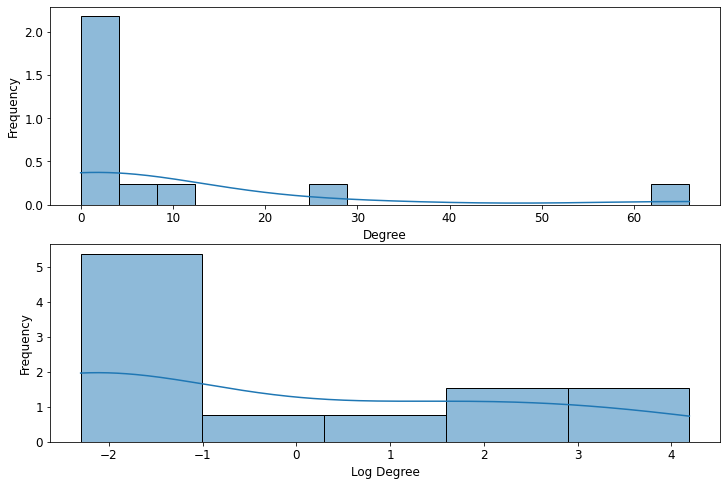

In [40]:

degree_freq = np.array(nx.degree_histogram(G)).astype('float')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plt.rcParams.update({'font.size': 12})

ax1 = sns.histplot(degree_freq, stat='frequency', kde=True, ax=ax1)
ax2 = sns.histplot(np.log(degree_freq+0.1), stat='frequency', kde=True, ax=ax2)
ax1.set(ylabel="Frequency", xlabel="Degree")
ax2.set(ylabel="Frequency", xlabel="Log Degree")
plt.show()

## 6. Network Centrality

Although we’re dealing with a very small and understandable network, these can easily scale up to uninterpretable complexity.

Centrality is a way to think about importance of nodes/edges in a graph. Depending on your domain/data, you should use different assumptions and this will naturally lead you to assess different centrality measures. Some of the ways you can quantify “importance” in a network: 
* amount of degree of connectivity
* average proximity to other nodes
* fraction of shortest paths that pass through node, etc.

Some applications that centrality measures can be used for:
* finding influential nodes in a social network
* identifying nodes that disseminate information to many nodes or prevent epidemics
* hubs in a transportation network
* important pages on the web
* nodes that prevent the network from breaking up

In [44]:
def get_centrality(sorted_centrality_teams, centrality_name):
    df = pd.DataFrame(sorted_centrality_teams, columns=['Team', centrality_name])
    return df
  
metric_main_df = pd.DataFrame(index=list(d.keys()))

degree_centrality_df = get_centrality(sorted(nx.degree_centrality(G).items(), key=lambda x:x[1], reverse=True), 'Degree Centrality')
closeness_centrality_df = get_centrality(sorted(nx.closeness_centrality(G).items(), key=lambda x:x[1], reverse=True), 'Closeness Centrality')
betweenness_centrality_df = get_centrality(sorted(nx.betweenness_centrality(G).items(), key=lambda x:x[1], reverse=True), 'Betweenness Centrality')
eigenvector_centrality_df = get_centrality(sorted(nx.eigenvector_centrality(G).items(), key=lambda x:x[1], reverse=True), 'Eigenvector Centrality')
pagerank_df = get_centrality(sorted(nx.pagerank(G).items(), key=lambda x:x[1], reverse=True), 'PageRank')

hub, auth = nx.hits(G)
hubs_df = get_centrality(sorted(hub.items(), key=lambda x:x[1], reverse=True), 'Hubs')
authorities_df = get_centrality(sorted(auth.items(), key=lambda x:x[1], reverse=True), 'Authorities')

for metric in [degree_centrality_df, closeness_centrality_df, betweenness_centrality_df, eigenvector_centrality_df, pagerank_df, hubs_df, authorities_df]:
    metric = metric.set_index('Team')
    metric_main_df = metric_main_df.join(metric)
    
metric_main_df

,Degree Centrality,Closeness Centrality,Betweenness Centrality,Eigenvector Centrality,PageRank,Hubs,Authorities
BrighamYoung,0.105263,0.423792,0.032490,0.106503,0.009588,0.010092,0.010092
FloridaState,0.105263,0.413043,0.017621,0.096385,0.009641,0.009132,0.009132
Iowa,0.105263,0.407143,0.013122,0.116262,0.009509,0.011017,0.011017
KansasState,0.105263,0.420664,0.023070,0.106250,0.009617,0.010069,0.010069
NewMexico,0.096491,0.402827,0.010664,0.101190,0.008887,0.009589,0.009589
...,...,...,...,...,...,...,...
TexasChristian,0.096491,0.413043,0.014370,0.114943,0.008777,0.010893,0.010893
California,0.096491,0.382550,0.007516,0.111198,0.008809,0.010538,0.010538
AlabamaBirmingham,0.087719,0.395833,0.011582,0.073015,0.008369,0.006918,0.006918
Arkansas,0.087719,0.377483,0.006498,0.070452,0.008369,0.006675,0.006675


### 6.1 Degree Centrality
Assumption: important nodes have **many connections**.

This is the most basic measure of centrality: number of neighbors. It uses degree for Undirected networks and in-degree or out-degree for Directed networks. The degree centrality values are commonly normalized by dividing by the maximum possible degree in a simple graph n-1 where n is the number of nodes in G.

`nx.degree_centrality(G).items()`

### 6.2 Closeness Centrality

Assumption: important nodes are **close** to other nodes.

$$C(v) = \sum_{u \ne v} \frac{N}{d(u, v)}$$

This is the **reciprocal** of the average shortest path distance to a node over all n-1 reachable nodes.

`nx.closeness_centrality(G).items()`

### 6.3 Betweenness Centrality

Assumption: important nodes are close to other nodes.

$$g(v) = \sum_{s \ne v \ne t} \frac{\sigma_{st}(v)}{\sigma_{st}}$$


Betweenness centrality of a node $v$ is the sum of the fraction of all-pairs shortest paths that pass through $v$. The formula essentially looks at the number of shortest paths between nodes $s$ and $t$ that **pass through node $v$** and divides it by all number of shortest paths between $s$ and $t$ (not containing $v$).

Since computation of this can be very expensive, it can be common to calculate this metric for a sample of node pairs. This metric can also be used to find important edges as well.

`nx.betweenness_centrality(G).items()`


### 6.4 Eigenvector Centrality

Assumption: important nodes are connected to **central** nodes.

$$A\bf{x} = \lambda \bf{x}$$

Eigenvector centrality computes the centrality for a node based on the centrality of its neighbors. It measures the **influence** of a node in a network. A high eigenvector score means that a node is connected to many nodes who themselves have high scores.

`nx.eigenvector_centrality(G).items()`


### 6.5 PageRank

Assumption: important nodes are those with many **in-links** from other important nodes.

Algorithm:

1. Start on a random node.
2. Assign all nodes a PageRank of 1/n.
3. Choose an outgoing edge at random and follow it to the next node.
4. Perform the Basic PageRank Update Rule: each node gives an equal share of its current PageRank to all the nodes it links to.
5. The new PageRank of each node is the sum of all the PageRank it received from other nodes.
6. Repeat k times.

This is the Google’s PageRank algorithm. It measures the importance of webpages from the **hyperlink** network structure. It assigns a score of importance to each node depending on how many links it has coming in from other nodes. In large networks, scaled PageRank is preferred as it comes with a “dampening parameter” alpha. This is a probability that an outgoing edge will be chosen at random to follow to another node in the algorithm which is especially beneficial when there’s a closed loop of outgoing nodes in a network.

`nx.pagerank(G).items()`